In [1]:
# import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import re
from config import client, client_secret

In [2]:
# define path to csv file
file_path = 'data/income-inequality-.csv'

# read economic data csv intp pandas df
econ_df = pd.read_csv(file_path)
econ_df.head()

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_name,county_fips,...,Gini_index,LL_95CI,UL_95CI,se,rse,CA_decile,CA_RR,Median_HH_income,Median_HH_decile,version
0,556,Income inequality: Gini coefficient describing...,2005-2007,9,Total,CA,6,California,NaN,NaN,...,0.468,0.465617,0.470383,0.001216,0.259787,NaN,NaN,NaN,NaN,03/26/2014 12:00:00 AM
1,556,Income inequality: Gini coefficient describing...,2006-2010,9,Total,CA,6,California,NaN,NaN,...,0.469,0.467809,0.470191,0.000608,0.129617,NaN,NaN,NaN,NaN,03/26/2014 12:00:00 AM
2,556,Income inequality: Gini coefficient describing...,2008-2010,9,Total,CA,6,California,NaN,NaN,...,0.471,0.468617,0.473383,0.001216,0.258133,NaN,NaN,NaN,NaN,03/26/2014 12:00:00 AM
3,556,Income inequality: Gini coefficient describing...,2005-2007,9,Total,CO,6001,Alameda,Alameda,6001.0,...,0.455,0.449043,0.460957,0.003040,0.668025,NaN,0.972222,66430.0,3.0,03/26/2014 12:00:00 AM
4,556,Income inequality: Gini coefficient describing...,2005-2007,9,Total,CO,6003,Alpine,Alpine,6003.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03/26/2014 12:00:00 AM


In [4]:
# drop rows where gini index or median household income is na
econ_df = econ_df.dropna(subset=['Gini_index', 'Median_HH_income'])
econ_df.describe()

,ind_id,race_eth_code,geotypevalue,county_fips,region_code,Number_Households,Gini_index,LL_95CI,UL_95CI,se,rse,CA_decile,CA_RR,Median_HH_income,Median_HH_decile
count,1967.0,1967.0,1967.000000,1967.000000,1967.000000,1.967000e+03,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1807.000000,1967.000000,1967.000000,1967.000000
mean,556.0,9.0,40210.172852,6057.173869,8.791561,3.565121e+04,0.415964,0.372627,0.459301,0.022111,5.429507,5.170448,0.886523,63383.262328,5.496187
std,0.0,0.0,26203.920773,29.458529,4.941290,1.609551e+05,0.051717,0.060967,0.062142,0.017034,4.230913,2.675667,0.110191,26992.619504,2.864499
min,556.0,9.0,135.000000,6001.000000,1.000000,6.700000e+01,0.112000,0.048851,0.175149,0.001216,0.247618,1.000000,0.238806,13588.000000,1.000000
25%,556.0,9.0,15522.000000,6037.000000,4.000000,1.703500e+03,0.386000,0.340117,0.420074,0.010334,2.541930,3.000000,0.823028,45191.500000,3.000000
50%,556.0,9.0,40354.000000,6059.000000,10.000000,8.838000e+03,0.413000,0.377319,0.449319,0.016413,3.993522,5.000000,0.880597,57240.000000,6.000000
75%,556.0,9.0,61068.000000,6079.000000,14.000000,2.311700e+04,0.444000,0.410245,0.487149,0.028571,6.956782,7.000000,0.946638,75753.000000,8.000000
max,556.0,9.0,87090.000000,6115.000000,14.000000,3.241204e+06,0.682000,0.577532,0.935213,0.156231,28.766826,10.000000,1.454158,223611.000000,10.000000


In [11]:
# There's multiple entries for each city because there are multiple report years. Let's average the data together by geoname
# Only interested in averaging Number_HOuseholds, Gini_index, CA_RR, Median_HH_income
temp_df = econ_df[['geoname', 'geotype', 'Number_Households', 'Gini_index', 'CA_RR', 'Median_HH_income']]
avg_econ_df = temp_df.groupby(['geoname', 'geotype']).mean()
# reset index
avg_econ_df.reset_index(inplace=True)

# filter for only cities (geo type == PL)
cities_df = avg_econ_df[avg_econ_df['geotype']=='PL']
# sort by number of households
cities_df = cities_df.sort_values(['Number_Households'], ascending=False)
# reset index
cities_df = cities_df.reset_index()
# drop original index column
cities_df = cities_df.drop(columns=['index'])

# regex to search for ' city' at the end of the string
p = re.compile(r' city$')
# remove the ' city' at the end of each geoname
cities_df['geoname'] = cities_df['geoname'].apply(lambda x: p.sub('', x))

# select the top n cities by population
cities_df.head()

,geoname,geotype,Number_Households,Gini_index,CA_RR,Median_HH_income
0,Los Angeles,PL,1318168.0,0.523667,1.115771,48058.666667
1,San Diego,PL,483092.0,0.463000,0.986490,61315.666667
2,San Francisco,PL,345811.0,0.507333,1.080976,69534.000000
3,San Jose,PL,301366.0,0.432000,0.920463,77969.333333
4,Sacramento,PL,174624.0,0.441333,0.940324,49225.666667


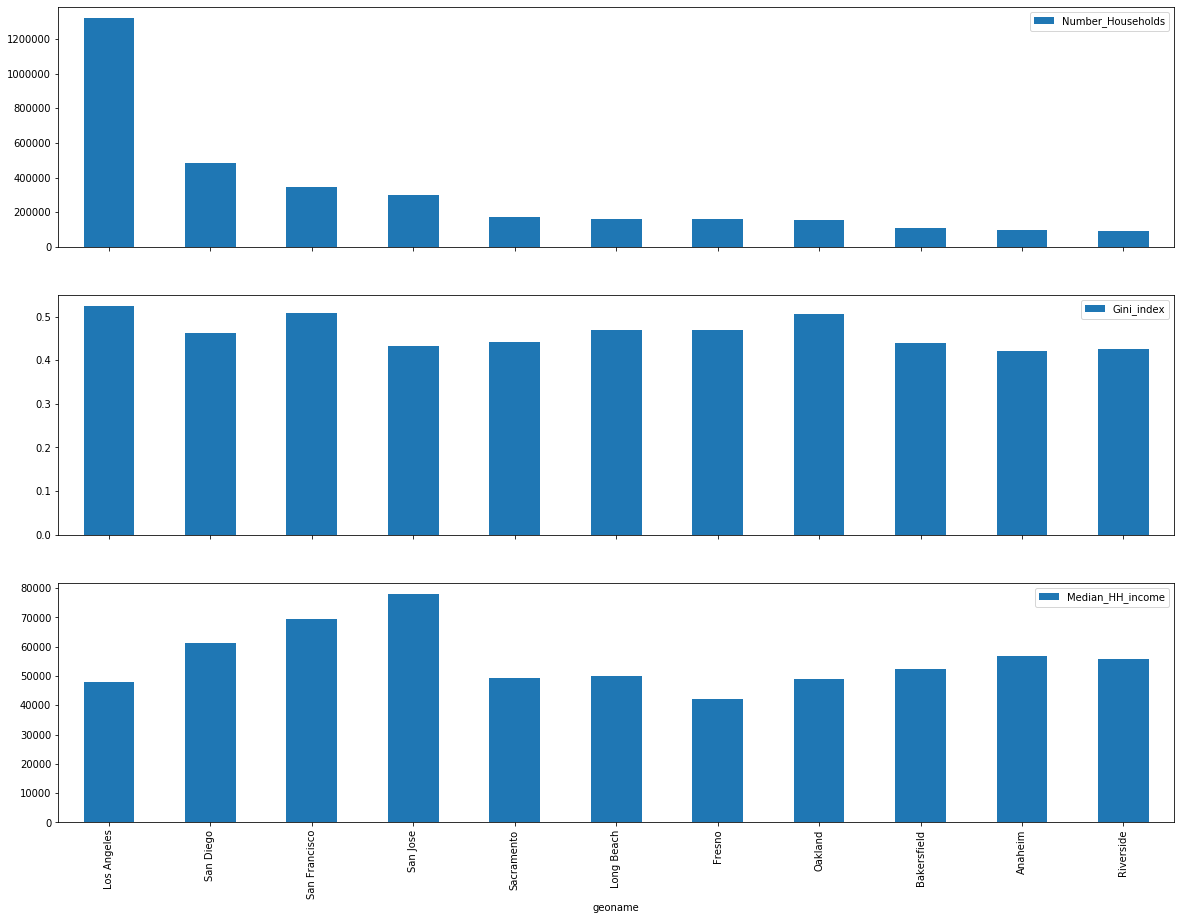

In [8]:
# create bargraphs of population, gini index, and median hh income
fig = plt.figure(figsize=(20,15))
# variable for how top n cities to show
n = 10
top_cities_df = cities_df.loc[0:n]

# create three subplots in a loop to graph all these
measures = ['Number_Households', 'Gini_index', 'Median_HH_income']
for i, measure in zip(range(1,4), measures):
    # create axes onbject
    axi = fig.add_subplot(3,1,i)
    # create graph
    top_cities_df.plot(kind='bar', x='geoname', y=measure, ax=axi, sharex=True)

Text(0.5, 1.0, 'Gini index vs Number of Households')

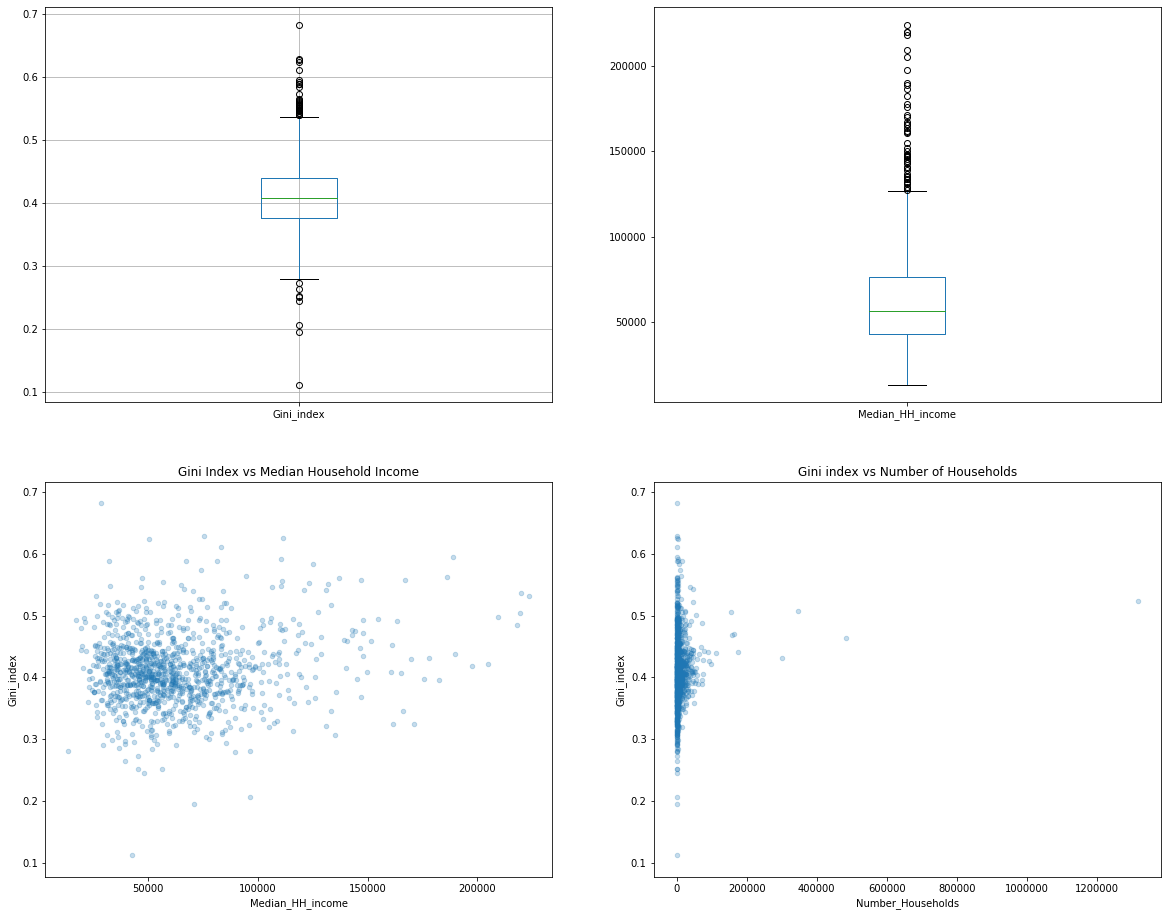

In [40]:
# let's visually explore the data
# create figure and axes objects for the subplots. These are graphed in a 2 x 2 grid
fig = plt.figure(figsize=(20,16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# make the top row box plots for gini and median incomes. This will visualize outliers
cities_df.boxplot(column='Gini_index', ax=ax1)
cities_df.plot(kind='box', y='Median_HH_income', ax=ax2)

# Use the bottom row for scatter plots showing relationships between variables
cities_df.plot(kind='scatter', x='Median_HH_income', y='Gini_index', ax=ax3, alpha=0.25)
ax3.set_title('Gini Index vs Median Household Income')

cities_df.plot(kind='scatter', x='Number_Households', y='Gini_index', ax=ax4, alpha=0.25)
ax4.set_title('Gini index vs Number of Households')

In [10]:
# Define function to build query url and make api call to 4square
def get_data(location, client=client, client_secret=client_secret, time='any', openNow=0, price='1,2,3,4', v='20191206'):
    """
    Takes the desired parameters, builds the search, and makes an api call to foursquare. Returns a json response.
    
    Currently the valid range of price points are [1,2,3,4], 1 being the least expensive, 4 being the most expensive. 
    For food venues, in the United States, 1 is < $10 an entree, 2 is $10-$20 an entree, 3 is $20-$30 an entree, 4 is > $30 an entree.
    """
    # assemble the parameters into search strings
    base_uri = 'https://api.foursquare.com/v2/venues/explore?'
    near = 'near=' + location + ', CA, United States'
    price = f'price={price}'
    time = f'time={time}'
    openNow = f'openNow={openNow}'
    authentication = f'client_id={client}&client_secret={client_secret}&v={v}'
    
    # join each seach parameter using '&'
    param_str = '&'.join([near, time, openNow, price, authentication])
    search_url = base_uri + param_str
    
    # make the api call
    response = requests.get(search_url)
    return response.json()
    

In [12]:
# Get the following data for each county: venue id, venue name, category name, and price
# price isn't returned in the response, but we can filter for it initially. We'll just need to make 1 request at each price point (1-4)
prices = range(1,5)

# slice the sorted df for the top n cities by households. We need to make 4 calls per city, and we have 950 calls per day. Max cities per day is 237
n = 200
locations = cities_df.loc[:n-1, 'geoname']

# create empty list to hold dictionaries for all venue data
all_venues = []

# loop through all counties
for location in locations:
    print(f'Getting data for {location}...')
    # make an api call for each price point
    for price in prices:
        r = get_data(location, price=price)
        
        # check if the response was 2XX
        code = str(r['meta']['code'])
        if code[0] != '2':
            print(f'Error {code}')
            continue
            
        # find the number of total results and just move on if it's 0 (don't try to process the data because there isn't any!)
        totalR = r['response']['totalResults']
        if totalR == 0:
            continue

        # locate where the venues data is stored
        venues = r['response']['groups'][0]['items']

        # loop through all the returned venues
        for venue in venues:
            v = venue['venue']

            # initialize empty dictionary to hold data for an individual venue
            venue_dict = {}

            # add data to venue_dict
            venue_dict = {
                'Venue id': v['id'],
                'Venue Name': v['name'],
                'Location': location,
                'Price': price
            }

            # get the list of categories. There may be more than 1.
            v_cat = v['categories']    
            # initialize index for number of subcategories
            subcategory = 1

            # Loop through eacch category in the list and extract the category name
            for cat in v_cat:
                # check if the category is the primary key
                if cat['primary']: 
                    venue_dict['Primary category'] = cat['name']
                # otherwise, create a unique column for each non-primary venue category
                else:
                    venue_dict[f'Subcategory {subcategory}'] = cat['name']
                    subcategory += 1

            # append the dictionary to the list for all our venues
            all_venues.append(venue_dict)
    print('Done!')
            
print('All data gathering complete!')

Getting data for Los Angeles...
Done!
Getting data for San Diego...
Done!
Getting data for San Francisco...
Done!
Getting data for San Jose...
Done!
Getting data for Sacramento...
Done!
Getting data for Long Beach...
Done!
Getting data for Fresno...
Done!
Getting data for Oakland...
Done!
Getting data for Bakersfield...
Done!
Getting data for Anaheim...
Done!
Getting data for Riverside...
Done!
Getting data for Stockton...
Done!
Getting data for Irvine...
Done!
Getting data for Chula Vista...
Done!
Getting data for Huntington Beach...
Done!
Getting data for Santa Ana...
Done!
Getting data for Glendale...
Done!
Getting data for Fremont...
Done!
Getting data for Modesto...
Done!
Getting data for Santa Rosa...
Done!
Getting data for Santa Clarita...
Done!
Getting data for San Bernardino...
Done!
Getting data for Oceanside...
Done!
Getting data for Torrance...
Done!
Getting data for Pasadena...
Done!
Getting data for Rancho Cucamonga...
Done!
Getting data for Sunnyvale...
Done!
Getting dat

In [13]:
# create a df to see our data for alemeda county
venues_df = pd.DataFrame(all_venues)
venues_df.head()

,Venue id,Venue Name,Location,Price,Primary category
0,427ff980f964a520c7211fe3,J. Paul Getty Museum,Los Angeles,1,Art Museum
1,4dee93a0d4c019425301dd4e,The Last Bookstore,Los Angeles,1,Bookstore
2,4eeb4c14b634b469c36a8c80,The Broad,Los Angeles,1,Art Museum
3,58a5368530ecc618cd3d30cf,Salt & Straw,Los Angeles,1,Ice Cream Shop
4,5801612a38fab747a494609b,Salt & Straw,Los Angeles,1,Ice Cream Shop


In [15]:
# how much data do we have?
venues_df.shape

(10735, 5)

In [16]:
# save venues_df to a csv so we don't have to make the api call every time
venues_df.to_csv('data/venues_data_by_city.csv')
print('Dataframe saved to csv!')

Dataframe saved to csv!


In [17]:
# What are the value counts for each county?
venue_counts = venues_df['Primary category'].value_counts()
venue_counts

Mexican Restaurant       996
Coffee Shop              937
Burger Joint             600
American Restaurant      588
Pizza Place              532
                        ... 
History Museum             1
Sporting Goods Shop        1
Soup Place                 1
Street Food Gathering      1
Hotel Pool                 1
Name: Primary category, Length: 172, dtype: int64

In [18]:
# Let's encode the prices with more descriptive categories
price_key = {1:'Low',
            2:'Moderate',
            3:'Expensive',
            4:'Very Expensive'}
# change the numbers in the price column to their string descriptions
venues_df['Price'] = [price_key[price] for price in venues_df['Price']]
venues_df.head()

,Venue id,Venue Name,Location,Price,Primary category
0,427ff980f964a520c7211fe3,J. Paul Getty Museum,Los Angeles,Low,Art Museum
1,4dee93a0d4c019425301dd4e,The Last Bookstore,Los Angeles,Low,Bookstore
2,4eeb4c14b634b469c36a8c80,The Broad,Los Angeles,Low,Art Museum
3,58a5368530ecc618cd3d30cf,Salt & Straw,Los Angeles,Low,Ice Cream Shop
4,5801612a38fab747a494609b,Salt & Straw,Los Angeles,Low,Ice Cream Shop


In [19]:
# get the frequency of each venue for each county. 
# One hot encode the venue categories
one_hot_venues = pd.get_dummies(venues_df, columns=['Primary category', 'Price'], prefix_sep=': ')
# gorup by the counties by mean to get the frequency opf each category
freq_df = one_hot_venues.groupby('Location').mean()
freq_df

,Primary category: Afghan Restaurant,Primary category: American Restaurant,Primary category: Arcade,Primary category: Argentinian Restaurant,Primary category: Art Museum,Primary category: Asian Restaurant,Primary category: Australian Restaurant,Primary category: Austrian Restaurant,Primary category: BBQ Joint,Primary category: Bagel Shop,...,Primary category: Wine Bar,Primary category: Wine Shop,Primary category: Winery,Primary category: Wings Joint,Primary category: Xinjiang Restaurant,Primary category: Zoo,Price: Expensive,Price: Low,Price: Moderate,Price: Very Expensive
Location,,,,,,,,,,,,,,,,,,,,,
Alameda,0.016393,0.032787,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.016393,0.000000,0.0,0.0,0.016393,0.491803,0.491803,0.000000
Alhambra,0.000000,0.034483,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.017241,0.0,0.000000,0.017241,0.0,0.0,0.068966,0.517241,0.413793,0.000000
Aliso Viejo,0.000000,0.060000,0.0,0.0,0.0,0.020000,0.0,0.0,0.000000,0.040000,...,0.020000,0.0,0.000000,0.000000,0.0,0.0,0.060000,0.440000,0.500000,0.000000
Anaheim,0.000000,0.051282,0.0,0.0,0.0,0.012821,0.0,0.0,0.012821,0.000000,...,0.025641,0.0,0.000000,0.000000,0.0,0.0,0.179487,0.384615,0.384615,0.051282
Antioch,0.000000,0.063830,0.0,0.0,0.0,0.042553,0.0,0.0,0.000000,0.021277,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.638298,0.361702,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Whittier,0.000000,0.076923,0.0,0.0,0.0,0.030769,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.046154,0.461538,0.461538,0.030769
Woodland,0.000000,0.022222,0.0,0.0,0.0,0.022222,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.044444,0.666667,0.266667,0.022222
Yorba Linda,0.000000,0.071429,0.0,0.0,0.0,0.023810,0.0,0.0,0.000000,0.023810,...,0.023810,0.0,0.000000,0.000000,0.0,0.0,0.071429,0.523810,0.404762,0.000000


In [20]:
# merge the economic and venue data
econ_venue_merged_df = pd.merge(cities_df, freq_df, left_on = 'geoname', right_on='Location')
econ_venue_merged_df

,geoname,geotype,Number_Households,Gini_index,CA_RR,Median_HH_income,Primary category: Afghan Restaurant,Primary category: American Restaurant,Primary category: Arcade,Primary category: Argentinian Restaurant,...,Primary category: Wine Bar,Primary category: Wine Shop,Primary category: Winery,Primary category: Wings Joint,Primary category: Xinjiang Restaurant,Primary category: Zoo,Price: Expensive,Price: Low,Price: Moderate,Price: Very Expensive
0,Los Angeles,PL,1318168.0,0.523667,1.115771,48058.666667,0.0,0.034091,0.0,0.000000,...,0.011364,0.011364,0.000000,0.000,0.0,0.000000,0.261364,0.340909,0.340909,0.056818
1,San Diego,PL,483092.0,0.463000,0.986490,61315.666667,0.0,0.038462,0.0,0.000000,...,0.012821,0.000000,0.012821,0.000,0.0,0.012821,0.192308,0.384615,0.384615,0.038462
2,San Francisco,PL,345811.0,0.507333,1.080976,69534.000000,0.0,0.013514,0.0,0.013514,...,0.040541,0.000000,0.000000,0.000,0.0,0.000000,0.229730,0.337838,0.405405,0.027027
3,San Jose,PL,301366.0,0.432000,0.920463,77969.333333,0.0,0.044776,0.0,0.000000,...,0.014925,0.000000,0.000000,0.000,0.0,0.000000,0.104478,0.447761,0.447761,0.000000
4,Sacramento,PL,174624.0,0.441333,0.940324,49225.666667,0.0,0.089744,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.179487,0.384615,0.384615,0.051282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,La Mirada,PL,14681.0,0.399333,0.850901,79084.333333,0.0,0.041667,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.062500,0.625000,0.312500,0.000000
183,Lynwood,PL,14680.0,0.388333,0.827392,41930.333333,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.025,0.0,0.000000,0.050000,0.725000,0.200000,0.025000
184,Huntington Park,PL,14597.0,0.412000,0.877803,35845.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.024390,0.731707,0.219512,0.024390
185,Martinez,PL,14287.0,0.396667,0.845186,75503.000000,0.0,0.050000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.025,0.0,0.000000,0.000000,0.750000,0.250000,0.000000


Text(0.5, 0, 'Percentage of Expensive ($$$) Venues')

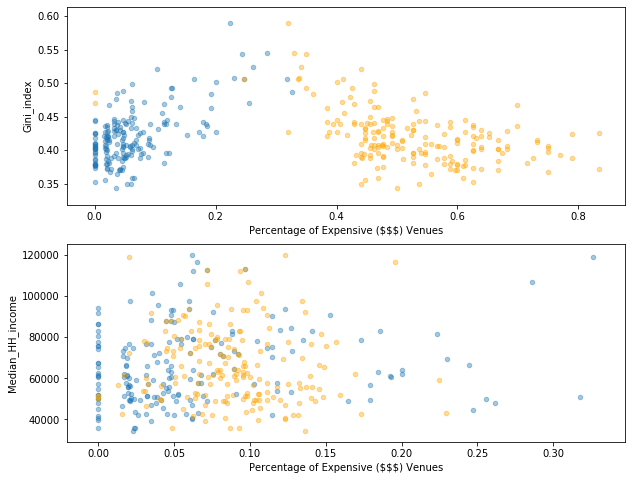

In [70]:
# make visualizations
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
econ_venue_merged_df.plot(kind='scatter', x='Price: Expensive', y='Gini_index', ax=ax1, alpha=0.4)
econ_venue_merged_df.plot(kind='scatter', x='Price: Low', y='Gini_index', ax=ax1, alpha=0.4, color='orange')
ax1.set_xlabel('Percentage of Expensive ($$$) Venues')
# ax1.set_ylim((.0,1))

ax2 = fig.add_subplot(212)
econ_venue_merged_df.plot(kind='scatter', x = 'Price: Expensive', y='Median_HH_income', alpha=0.4, ax=ax2)
econ_venue_merged_df.plot(kind='scatter', x = 'Primary category: Coffee Shop', y='Median_HH_income', alpha=0.4, ax=ax2, color = 'orange')

ax2.set_xlabel('Percentage of Expensive ($$$) Venues')


In [23]:
freq_df.describe()

,Primary category: Afghan Restaurant,Primary category: American Restaurant,Primary category: Arcade,Primary category: Argentinian Restaurant,Primary category: Art Museum,Primary category: Asian Restaurant,Primary category: Australian Restaurant,Primary category: Austrian Restaurant,Primary category: BBQ Joint,Primary category: Bagel Shop,...,Primary category: Wine Bar,Primary category: Wine Shop,Primary category: Winery,Primary category: Wings Joint,Primary category: Xinjiang Restaurant,Primary category: Zoo,Price: Expensive,Price: Low,Price: Moderate,Price: Very Expensive
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,...,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,0.000573,0.053916,0.000094,0.000673,0.000255,0.012920,0.000263,0.000060,0.012766,0.004726,...,0.005061,0.000146,0.002040,0.005556,0.000109,0.000069,0.063115,0.522969,0.396467,0.017450
std,0.003181,0.032015,0.001283,0.003474,0.002677,0.015221,0.002188,0.000822,0.015726,0.009869,...,0.009961,0.001424,0.010744,0.011093,0.001492,0.000938,0.065617,0.122070,0.087469,0.024078
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.032522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.452273,0.353554,0.000000
50%,0.000000,0.048387,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046154,0.508475,0.405405,0.015385
75%,0.000000,0.075615,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.020833,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076340,0.600000,0.457627,0.025321
max,0.022222,0.159091,0.017544,0.023256,0.034091,0.057692,0.024390,0.011236,0.083333,0.066667,...,0.053333,0.015873,0.106667,0.045455,0.020408,0.012821,0.326531,0.833333,0.697674,0.138298


In [36]:
# how many venues were returned at each city?
num_venues = venues_df.groupby('Location').count()
# keep only the first column
num_venues = num_venues.iloc[:,[0]]
# rename column to indicate it's the count
num_venues = num_venues.rename(columns={'Venue id':'Venue Count'})
# descibe the data. What city had the fewest returned venues? What about the max?
num_venues.describe()

,Venue Count
count,187.000000
mean,57.406417
std,11.650629
min,32.000000
25%,48.000000
50%,57.000000
75%,65.000000
max,94.000000


In [39]:
for c in econ_venue_merged_df.columns:
    print(c)

geoname
geotype
Number_Households
Gini_index
CA_RR
Median_HH_income
Primary category: Afghan Restaurant
Primary category: American Restaurant
Primary category: Arcade
Primary category: Argentinian Restaurant
Primary category: Art Museum
Primary category: Asian Restaurant
Primary category: Australian Restaurant
Primary category: Austrian Restaurant
Primary category: BBQ Joint
Primary category: Bagel Shop
Primary category: Bakery
Primary category: Bar
Primary category: Baseball Stadium
Primary category: Basketball Stadium
Primary category: Beer Bar
Primary category: Beer Garden
Primary category: Beer Store
Primary category: Big Box Store
Primary category: Bistro
Primary category: Bookstore
Primary category: Brazilian Restaurant
Primary category: Breakfast Spot
Primary category: Brewery
Primary category: Bubble Tea Shop
Primary category: Buffet
Primary category: Burger Joint
Primary category: Burmese Restaurant
Primary category: Burrito Place
Primary category: Butcher
Primary category: Ca